# General Data Processing

In this Notebook I use the data from Quantum Espresso to visualize various things.

This notebook serves the purpose of testing all the written functions, that don't fit in any other notebook.

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import importlib
np.set_printoptions(precision=3, suppress=True)
# finalized libs
pass
# not finalized libs
import qespresso_interface as qe
importlib.reload(qe)
import symmetry
importlib.reload(symmetry)
import fermi_surface as fs
importlib.reload(fs)
import density_of_states as dos
importlib.reload(dos)
import bulk_properties as bulk
importlib.reload(bulk);

found inversion symmetry
9261 9261


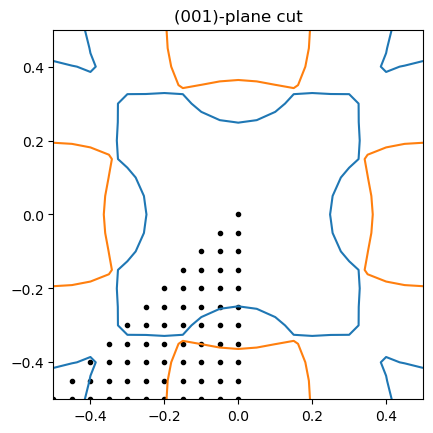

In [2]:
import symmetry
importlib.reload(symmetry)

# correct 2d fermi surface cuts from ./tmp/nitinol_0K.xml

material = qe.QECrystal("nitinol_0K", [], [], [], 0)
k_smpl, weights, bands, symmetries, fermi_energy = material.read_bands()

select = k_smpl[:,0] == 0
#plt.plot(k_smpl[select,1], k_smpl[select,2], "k.")

sym_count = len(k_smpl)
sym = symmetry.Symmetry(symmetries)
k_smpl, bands = sym.realize_symmetric_data(k_smpl, bands)

dim = 3
print(len(k_smpl), 21**3)
n = round(len(k_smpl)**(1/dim))
assert n**dim == len(k_smpl)
# this reduced data is actually cleaner than the version from quantum espresso
reduced_k = sym.reduce_symmetric_data(k_smpl, bands)[0]
assert sym_count == len(reduced_k)

select = reduced_k[:,0] == 0
plt.plot(reduced_k[select,1], reduced_k[select,2], "k.")

select = k_smpl[:,0] == 0
#plt.scatter(k_smpl[select,1], k_smpl[select,2], 10.0, c=np.arange(len(k_smpl))[select] % (21 * 21))
#plt.scatter(k_smpl[select,1], k_smpl[select,2], 10.0, c=np.arange(len(k_smpl))[select] % 21)
#plt.scatter(k_smpl[select,1], k_smpl[select,2], 10.0, c=np.arange(len(k_smpl))[select])
#plt.colorbar()
for band_index in range(len(bands[0])):
    xy = k_smpl[select,1:]
    z = bands[select, band_index] - fermi_energy
    if not (np.any(z > 0) and np.any(z < 0)):
        continue
    
    #plt.tricontour(xy[:,0], xy[:,1], z, levels=(0.,), colors=f"C{band_index-14}")
    # because it is well sorted one can actually do this:
    plt.contour(xy[:,0].reshape((21, 21)), xy[:,1].reshape((21, 21)), z.reshape((21, 21)), levels=(0.,), colors=f"C{band_index-14}")

plt.gca().set_aspect("equal")
plt.title("(001)-plane cut")
plt.show()

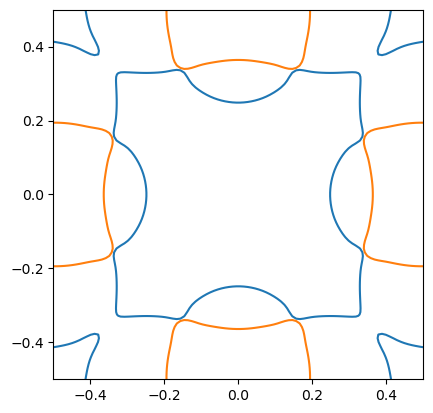

In [3]:
# trilinear/tricubic interpolation
import scipy.interpolate as interp

select = k_smpl[:,0] == 0
used_k_smpl = k_smpl[select,1:].reshape((21, 21, 2)).swapaxes(0, 2)#.swapaxes(1, 2)
#print(used_k_smpl[1])
interpolator = interp.RegularGridInterpolator((used_k_smpl[0][:,0], used_k_smpl[1][0,:]),
                                              bands[select].reshape((21, 21, -1)),
                                              method="cubic")
lin = np.linspace(-0.5, 0.5, 100)
x, y = np.meshgrid(lin, lin)
xy = np.stack((x, y), axis=-1)
z_unshifted = interpolator(xy)

for band_index in range(len(bands[0])):
    z = z_unshifted[:,:,band_index] - fermi_energy
    if not (np.any(z > 0) and np.any(z < 0)):
        continue
    plt.contour(xy[:,:,0], xy[:,:,1], z, levels=(0.,), colors=f"C{band_index-14}")
plt.gca().set_aspect("equal")
plt.show()

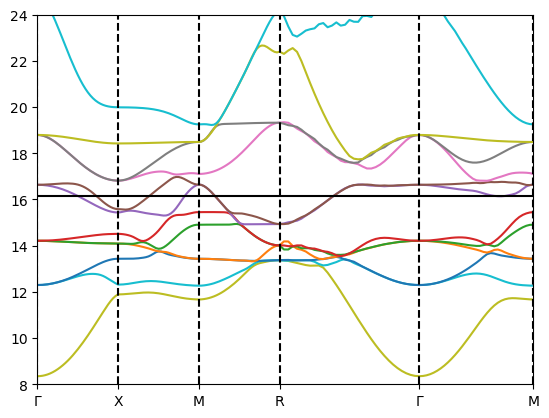

In [4]:
import kpaths
importlib.reload(kpaths)

# trilinear/tricubic interpolation
import scipy.interpolate as interp

used_k_smpl = k_smpl.reshape((21, 21, 21, 3)).T
#print(used_k_smpl[2])
interpolator = interp.RegularGridInterpolator((used_k_smpl[0][:,0,0], used_k_smpl[1][0,:,0], used_k_smpl[2][0,0,:]),
                                              bands.reshape((21, 21, 21, -1)),
                                              method="cubic")

path = kpaths.KPath('G').to('X').to('M').to('R').to('G').to('M')
#print(np.array(path))
ibands = interpolator(np.array(path)/2) # different units here...
x_smpl = path.x()
for i in range(len(ibands[0])):
    plt.plot(x_smpl, ibands[:,i])
for sym_x in path.sym_x():
    plt.axvline(sym_x, color="k", linestyle="dashed")
plt.xticks(path.sym_x(), path.sym_x_names())
plt.xlim(np.min(x_smpl), np.max(x_smpl))
plt.axhline(fermi_energy, color='k')
plt.ylim(8, 24)
plt.show()

Now do the same using the `kpaths` API

found inversion symmetry
Electrons per Unit-Cell: 15
Naive Fermi Energy: 16.162355990940373
QE  Fermi Energy: 16.157399621460513
DOS Fermi Energy: 16.18175745335538


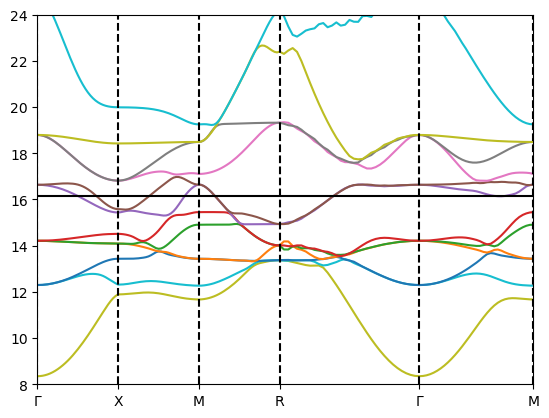

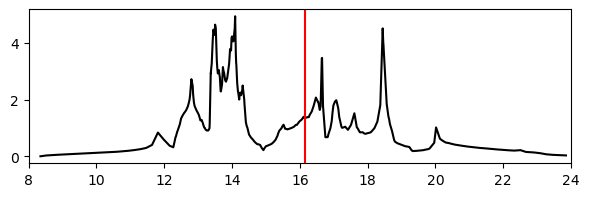

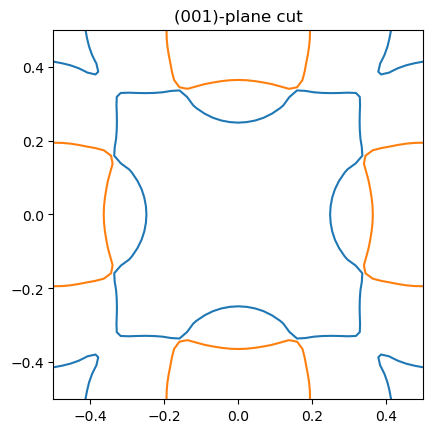

In [5]:
import kpaths
importlib.reload(kpaths)
import fermi_surface
importlib.reload(fermi_surface)
import density_of_states as dos
importlib.reload(dos)

material = qe.QECrystal("nitinol_0K", [], [], [], 0)
k_smpl, weights, bands, symmetries, fermi_energy = material.read_bands()

sym = symmetry.Symmetry(symmetries)
interpolator = kpaths.interpolate(k_smpl, bands, sym, method='cubic')

path = kpaths.KPath('G').to('X').to('M').to('R').to('G').to('M')
path.plot(interpolator)
plt.axhline(fermi_energy, color='k')
plt.ylim(8, 24)

# TODO add this plot sideways to the top plot
dos_model = dos.DensityOfStates(interpolator, N=10, ranges=((0.0, 0.5),)*3, wrap=False)
neutral_electrons = round(dos_model.states_below(fermi_energy))
print("Electrons per Unit-Cell:", neutral_electrons)
print("Naive Fermi Energy:", dos.naive_fermi_energy(bands, neutral_electrons))
print("QE  Fermi Energy:", fermi_energy)
print("DOS Fermi Energy:", dos_model.fermi_energy(neutral_electrons))
plt.show()

energy_smpl, states, density = dos_model.full_curve(N=30)
select = (energy_smpl > 8) & (energy_smpl < 24)
plt.figure(figsize=(7, 2))
plt.plot(energy_smpl[select], density[select], 'k-')
plt.axvline(fermi_energy, color='r')
plt.xlim(8, 24)
plt.show()

fermi_surface.plot_2D_fermi_surface(interpolator, fermi_energy, z=[0.0], N=45)

# Test Symmetry Functions

In [6]:
import symmetry
importlib.reload(symmetry)

# test Symmetry.symmetrize
sym = symmetry.Symmetry.from_generator([np.eye(3), ((1,0,0), (0,0,1), (0,-1,0))], True)
tensor = [[1, 2, 3], [4, 5, 6], [7, 8, 15]]
print("symmetries:", len(sym.S))
tensor = sym.symmetrize(tensor)
print(tensor)
tensor = sym.symmetrize(tensor)
print(tensor)
print()

sym = symmetry.Symmetry.from_generator([np.eye(3), ((0,1,0), (0,0,1), (1,0,0))], True)
tensor = [[1, 2, 3], [4, 5, 6], [7, 8, 15]]
print("symmetries:", len(sym.S))
tensor = sym.symmetrize(tensor)
print(tensor)
tensor = sym.symmetrize(tensor)
print(tensor)

sym = symmetry.Symmetry.from_generator([np.eye(3), ((1,0,0), (0,0,1), (0,-1,0)), ((0,1,0), (0,0,1), (1,0,0))], True)
tensor = [[1, 2, 3], [4, 5, 6], [7, 8, 15]]
print("symmetries:", len(sym.S))
tensor = sym.symmetrize(tensor)
print(tensor)
tensor = sym.symmetrize(tensor)
print(tensor)

symmetries: 4
[[ 1.  0.  0.]
 [ 0. 10. -1.]
 [ 0.  1. 10.]]
[[ 1.  0.  0.]
 [ 0. 10. -1.]
 [ 0.  1. 10.]]

symmetries: 3
[[7. 5. 5.]
 [5. 7. 5.]
 [5. 5. 7.]]
[[7. 5. 5.]
 [5. 7. 5.]
 [5. 5. 7.]]
symmetries: 24
[[7. 0. 0.]
 [0. 7. 0.]
 [0. 0. 7.]]
[[7. 0. 0.]
 [0. 7. 0.]
 [0. 0. 7.]]


# Test Representation Properties

Test using sympy, what forms the matrices in the symmetrized Hamilton operator can take on.

In [4]:
import unitary_representations as urep
importlib.reload(urep)
UR = urep.UnitaryRepresentation
import sympy as S

def mat(n, m=None, letter='x'):
    if m is None:
        m = n
    return S.Matrix([[S.Symbol(f"{letter}_{{{j}{i}}}") for i in range(m)] for j in range(n)])

irreps = [
    # 1D
    #UR.one_dim(False, False, True), UR.one_dim(True, False, True), UR.one_dim(False, True, True), UR.one_dim(True, True, True),
    # 2D
    UR.d3(False, sqrt3=S.sqrt(3)), UR.d3(True, sqrt3=S.sqrt(3)),
    # 3D
    #UR.so3(), UR.o3(), UR.o3r(), UR.o3ri(),
]
irrep_names = [
    #"(1, 1)", "(-1, 1)", "(1, -1)", "(-1, -1)",
    "(D3, 1)", "(D3, -1)",
    #"(O, 1)", "(O, -1)", "(-O, 1)", "(-O, -1)",
]

sym = symmetry.Symmetry.cubic(True)
neighbors = [(1, 1, 1)]
neighbors, _ = sym.realize_symmetric_data(neighbors, [[0]])
neighbors = [n for n in neighbors if n[0] > 0 or (n[0] == 0 and (n[1] > 0 or (n[1] == 0 and n[2] >= 0)))]
print(len(neighbors))
for i, Ua in enumerate(irreps):
    # test how Ua behaved on the diagonal terms
    Ua_n = len(Ua.U[0])
    M = mat(Ua_n)
    M = M + M.T
    params = [np.array(M)] + [np.zeros((Ua_n, Ua_n)) for _ in range(1, len(neighbors))]
    params = np.array(params)
    M = S.Matrix(Ua.symmetrize(params, neighbors)[0])
    M = S.nsimplify(S.cancel(S.expand(len(neighbors) * M)), rational=True)
    #display(M)
    # simplify further using substitution of the entries
    entry_set = set(np.ravel(M))
    if 0 in entry_set:
        entry_set.remove(0)
    entries = {k: S.Symbol(chr(ord('a') + i)) for i, k in enumerate(entry_set)}
    display(M.subs(entries))

4


Matrix([
[a, 0],
[0, a]])

Matrix([
[a, 0],
[0, a]])

In [14]:
sym = symmetry.Symmetry.cubic(True)
neighbors = [(1, 1, 1)]
neighbors, _ = sym.realize_symmetric_data(neighbors, [[0]])
neighbors = [n for n in neighbors if n[0] > 0 or (n[0] == 0 and (n[1] > 0 or (n[1] == 0 and n[2] >= 0)))]
print(len(neighbors))
for i, (Ua, name_a) in enumerate(zip(irreps, irrep_names)):
    for j, (Ub, name_b) in enumerate(zip(irreps[i:], irrep_names[i:])):
        # test how each combination behaves
        print(name_a, name_b)
        Ua_n = len(Ua.U[0])
        Ub_n = len(Ub.U[0])
        A = np.array(mat(Ua_n, letter='a'))
        A = A + A.T
        B = np.array(mat(Ub_n, letter='b'))
        B = B + B.T
        M = np.array(mat(Ua_n, Ub_n, letter='x'))
        # piece together this blockmatrix
        P = np.block([[A, M], [M.T, B]])
        params = [np.array(P)] + [np.zeros((Ua_n + Ub_n,)*2) for _ in range(1, len(neighbors))]
        params = np.array(params)
        P = S.Matrix((Ua + Ub).symmetrize(params, neighbors)[0][Ua_n:,:Ua_n])
        P = S.nsimplify(S.cancel(S.expand(len(neighbors) * P)), rational=True)
        #display(P)
        # simplify further using substitution of the entries
        entry_set = set(np.ravel(P))
        if 0 in entry_set:
            entry_set.remove(0)
        entries = {k: S.Symbol(chr(ord('a') + i)) for i, k in enumerate(entry_set)}
        display(P.subs(entries))
        #break # uncomment this line to only see equal irrep results

4
(1, 1) (1, 1)


Matrix([[a]])

(1, 1) (-1, 1)


Matrix([[0]])

(1, 1) (1, -1)


Matrix([[0]])

(1, 1) (-1, -1)


Matrix([[a]])

(-1, 1) (-1, 1)


Matrix([[a]])

(-1, 1) (1, -1)


Matrix([[a]])

(-1, 1) (-1, -1)


Matrix([[0]])

(1, -1) (1, -1)


Matrix([[a]])

(1, -1) (-1, -1)


Matrix([[0]])

(-1, -1) (-1, -1)


Matrix([[a]])

In [9]:
# write out the matrix for a tight binding model
import tight_binding as tb
import unitary_representations
UR = unitary_representations.UnitaryRepresentation
urepr = UR.one_dim(False, False, True) + UR.one_dim(True, True, True)
sym = symmetry.Symmetry.cubic(True)
neighbors = [(0, 0, 0), (0, 0, 1), (0, 1, 1), (1, 1, 1)]
neighbors, _ = sym.realize_symmetric_data(neighbors, [[0]]*len(neighbors))
neighbors = [n for n in neighbors if n[0] > 0 or (n[0] == 0 and (n[1] > 0 or (n[1] == 0 and n[2] >= 0)))]
#print(np.array(neighbors))
params = [np.array(mat(urepr.dim(), letter=f'a^{i}')) for i, n in enumerate(neighbors)]
#tb_sympy = tb.TightBindingModel(urepr, neighbors, params)
#tb_sympy.f([S.Array(list(S.symbols("k_x k_y k_z")))])

AttributeError: 'ImmutableDenseNDimArray' object has no attribute 'as_coefficient'

# Testing Bulk Properties

In [9]:
from bandstructure import *
# read the data from Bandx.dat from Quantum Espresso
import qespresso_interface as qe
material = qe.QECrystal("nitinol_0K", [], [], [], 0)
k_smpl, ref_bands = material.read_bandx_raw()
all_ref_bands = ref_bands
ref_bands = ref_bands[:,8:]
neutral_electrons = 7

# now start my algorithm to find good matrices
additional_bands = 0
band_offset = 0 # = additional bands below reference

weights = np.ones(len(ref_bands[0]))
weights[0] = 0.005
weights[1] = 0.005
weights[2] = 0.05
weights[3] = 0.5
weights[-1] = 0.005
weights[-2] = 0.05
weights[-3] = 0.5

neighbors = ((0, 0, 0), (1, 0, 0), (1, 1, 0), (1, 1, 1), (2, 0, 0), (2, 1, 0), (2, 1, 1), (2, 2, 1), (2, 2, 2), (3, 0, 0)) # works well
tb_nitinol = BandStructureModel.init_tight_binding_from_ref(symmetry.Symmetry.cubic(True), neighbors, k_smpl, ref_bands, band_offset, additional_bands)
tb_nitinol.normalize()
tb_nitinol.optimize(k_smpl, 1, ref_bands, weights, band_offset, 2000, 4)

loss: 9.79e-02
loss: 3.20e-02
loss: 1.53e-02
loss: 8.45e-03
loss: 5.95e-03
loss: 4.86e-03
loss: 4.42e-03
loss: 4.23e-03
loss: 4.11e-03
loss: 4.01e-03
loss: 3.93e-03
loss: 3.85e-03
loss: 3.77e-03
loss: 3.70e-03
loss: 3.64e-03
loss: 3.59e-03
loss: 3.53e-03
loss: 3.48e-03
loss: 3.43e-03
loss: 3.39e-03
final loss: 3.36e-03


# Linear Test Model

[(1.0, 2.5), (2.0, 5.0), (3.0, 7.5), (4.0, 10.0)]


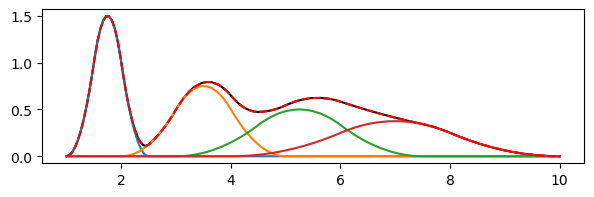

chemical potential: 4.200556218615938
sigma: 3.254709637343655e+21


In [10]:
import bulk_properties as bulk
importlib.reload(bulk)
import density_of_states as dos
importlib.reload(dos)

class LinearModel:
    def __init__(self):
        pass

    def __call__(self, k_smpl):
        return (np.sum(np.abs(k_smpl), axis=-1, keepdims=True) + 1) * [1, 2, 3, 4]
    
    def bands_grad(self, k_smpl):
        base = np.ones_like(k_smpl) * np.sign(k_smpl)
        base = base[...,None]
        return self(k_smpl), base * [1, 2, 3, 4]

linear = LinearModel()
#print(linear([[1, 1, 1], [1, 1, -2]]))
dos_model = dos.DensityOfStates(linear, N=23, ranges=((0.0, 0.5),)*3, wrap=False)
print(dos_model.bands_range)
energy_smpl, states, density = dos_model.full_curve(N=30)
plt.figure(figsize=(7, 2))
plt.plot(energy_smpl, density, 'k-')

a = [1, 2, 3, 4]
c = [1, 2, 3, 4]
# analytic state density
density2 = []
density_bands = []
for e in energy_smpl:
    b = []
    for c_, a_ in zip(c, a):
        x = (e - a_) / c_
        lim = (x > 0.0) & (x < 1.5)
        rho = 1/abs(c_) * 8/2 * (x**2 - 3*max(0, x - 0.5)**2 + 3*max(0, x - 1)**2) * lim
        b.append(rho)
    density2.append(sum(b))
    density_bands.append(b)
# show the contributions of the individual bands
plt.plot(energy_smpl, density_bands)
#plt.plot(energy_smpl, [dos_model.density_bands(e) for e in energy_smpl])
plt.plot(energy_smpl, density2, 'r--')
plt.show()

# analytic sigma
T = 300
beta = 1 / (dos.k_B * T)
mu = dos_model.chemical_potential(2, [T], N=40)
print("chemical potential:", *mu)
cell_length = 2.993e-10
k_unit = np.pi/2/cell_length # 1/m
def foo(mu):
    sigma_T0 = 0
    for c_, a_ in zip(c, a):
        x = (mu - a_) / c_
        lim = (x > 0.0) & (x < 1.5)
        rho_i = 1/np.abs(c_) * 8/2 * (x**2 - 3*np.maximum(0, x - 0.5)**2 + 3*np.maximum(0, x - 1)**2) * lim
        sigma_T0 += rho_i * c_**2 * (bulk.eV / k_unit / bulk.hbar)**2
    return sigma_T0
sigma_T0 = dos.gauss_7_df(foo, mu, beta)
print("sigma:", (2 * bulk.elementary_charge**2/bulk.eV / cell_length**3) * sigma_T0)

2.234388348048115 70.94480107802123 0.9280906028249567


/media/Daten/userfiles/Dokumente/Studium/Semester9/Masterarbeit/Library/density_of_states.py:113: RuntimeWarning: divide by zero encountered in divide
  com = np.where(area[...,None] != 0, com / area[...,None], np.reshape((0, 0, 0), shape))
/media/Daten/userfiles/Dokumente/Studium/Semester9/Masterarbeit/Library/density_of_states.py:113: RuntimeWarning: invalid value encountered in divide
  com = np.where(area[...,None] != 0, com / area[...,None], np.reshape((0, 0, 0), shape))


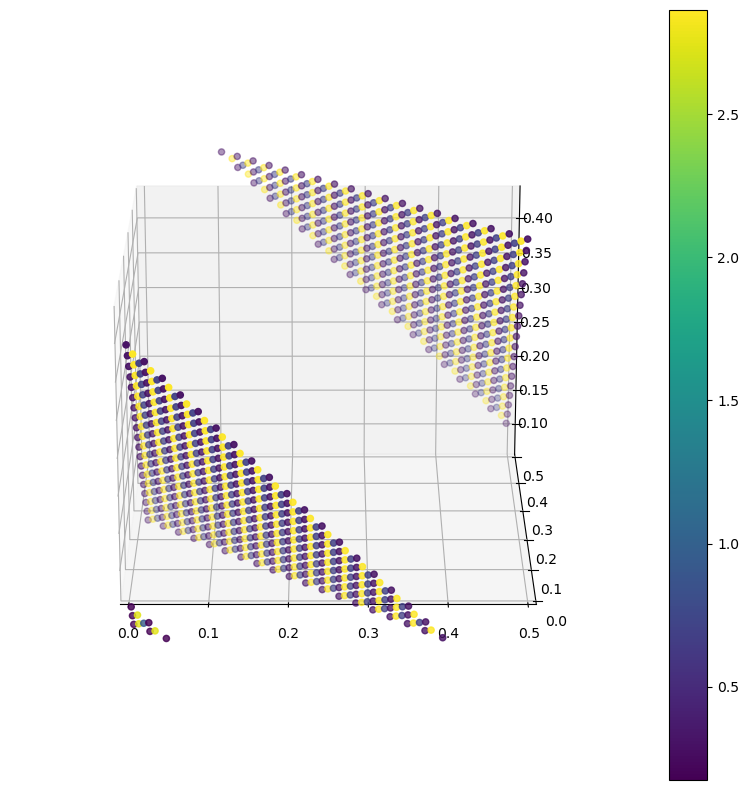

In [11]:
fermi_energy = 4.2
points, indices, weights, area = dos_model.fermi_surface_samples(fermi_energy, improved=True)
# compare octahedron surface with density (constant band gradients -> density ~ area)
# the following density formula works until the second band starts at 2.0
# the following area formula works until 1.5
print(area, 8*3**.5/2*(fermi_energy-1)**2, dos_model.density(fermi_energy) * 3**.5)
weights *= area * len(dos_model.cubes[0][0].flat) * 0.5/23
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
cmap = ax.scatter(points[:,0], points[:,1], points[:,2], c=weights)
ax.set_xlim(0.0, 0.5)
ax.set_ylim(0.0, 0.5)
ax.set_zlim(0.0, 0.5)
ax.set_aspect("equal")
#ax.view_init(elev=30, azim=-110)
ax.view_init(elev=20, azim=-90)
plt.colorbar(cmap)
plt.show()

In [12]:
import bulk_properties as bulk

model = tb_nitinol
electrons = neutral_electrons

#model = linear
#electrons = 2

T = 300
dos_model = dos.DensityOfStates(model, N=24, ranges=((0.0, 0.5),)*3, wrap=False)
mu = dos_model.chemical_potential(electrons, [T], N=40)[0]
print("chemical potential:", mu)
# calculate conductivity (Czycholl page 269)
beta = 1 / (dos.k_B * T) # in 1/eV
alat = 2.993e-10 # m
k_unit = np.pi/2/alat # 1/m
def fermi(x):
    #return 1 / (1 + np.exp(x))
    return (np.tanh(-0.5 * x) + 1) * 0.5
def dfermi(x): # ~ exp(-x*x/5)/4
    #e = np.exp(x)
    #return -1 / (e + 2 + 1/e)
    return -0.25 / np.cosh(0.5 * x)**2
N = 32
k_smpl = np.meshgrid(*3*(np.linspace(0, 0.5, N, endpoint=False),))
k_smpl += np.random.random(np.shape(k_smpl)) * ((0.5 - 0) / N) # this improves the integral a lot because it breaks symmetry -> *len(sym_group) integration sites
k_smpl = np.stack(k_smpl, axis=-1).reshape(-1, 3)
bands, grads = model.bands_grad(k_smpl)
v = grads * (bulk.eV / k_unit / bulk.hbar) # in m/s
#print(np.mean(np.mean(np.abs(v), axis=0), axis=1))
#print(np.mean(v)/np.mean(np.abs(v))) # this should be 0 for perfect sampling
# simplest integral formula
data = np.einsum("iaj,ibj,ij->iab", v, v, -dfermi((bands - mu) * beta))
I = np.mean(data, axis=0) # result is m^2/s^2 /beta ?
err = np.std(data, axis=0) / len(data)**0.5
sigma = 2 * bulk.elementary_charge**2 * (beta*I)/bulk.eV / alat**3 # result is in 1/(Ohm*m)
sym = symmetry.Symmetry.cubic(True)
sigma = sym.symmetrize(sigma)
avg_sigma = np.trace(sigma)/3
print(f"{sigma/avg_sigma}*{avg_sigma:.3e}\nwith error\n{err/np.abs(I)*100}%")

chemical potential: 16.183385343379715
[[ 1. -0. -0.]
 [-0.  1.  0.]
 [-0.  0.  1.]]*1.125e+22
with error
[[2.005 5.142 5.171]
 [5.142 1.996 5.224]
 [5.171 5.224 1.99 ]]%


In [13]:
import bulk_properties as bulk
importlib.reload(bulk)
importlib.reload(dos)
import symmetry
importlib.reload(symmetry)

T = 300
model = tb_nitinol
electrons = neutral_electrons
#model = linear
#electrons = 2

dos_model = dos.DensityOfStates(model, N=24, ranges=((0.0, 0.5),)*3, wrap=False)
mu = dos_model.chemical_potential(electrons, [T], N=40)
print("chemical potential:", *mu)
sigma_over_tau = bulk.conductivity_over_tau(dos_model, electrons, 2.993e-10, T=T, mu=mu, print_error=True)
sym = symmetry.Symmetry.from_generator([np.eye(3), ((1,0,0), (0,0,1), (0,-1,0))], True)
sigma_over_tau = sym.symmetrize(sigma_over_tau)
mean_sigma = np.trace(sigma_over_tau)/3
print(sigma_over_tau / mean_sigma)
print("conductivity", mean_sigma, "× τ")

# without symmetry:
#dos_model = dos.DensityOfStates(model, N=24, ranges=((-0.5, 0.5),)*3, wrap=False)
#sigma_over_tau = bulk.conductivity_over_tau(dos_model, electrons, 2.993e-10, T=T, mu=mu)
#mean_sigma = np.trace(sigma_over_tau)/3
#print(sigma_over_tau / mean_sigma)
#print("conductivity", mean_sigma, "× τ")

chemical potential: 16.183385343379715
error: 0.029109%
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
conductivity 1.1202298668498798e+22 × τ


12.775695428643125
12.440716451338417
11.677963010206684
11.140688686924845
10.832978047345092
10.231031454272303
7.862600084327311


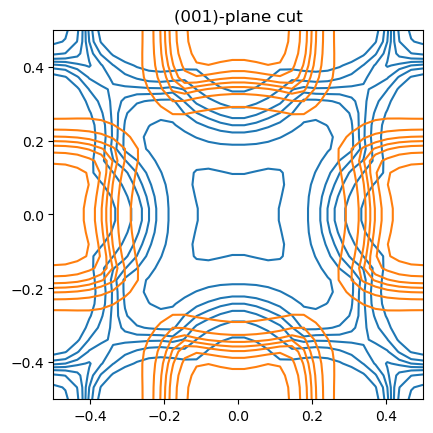

In [14]:
import fermi_surface
importlib.reload(fermi_surface)

T = 300
model = tb_nitinol
electrons = neutral_electrons
#model = linear
#electrons = 2

beta = 1 / (dos.k_B * T) # in 1/eV
dos_model = dos.DensityOfStates(model, N=24, ranges=((0.0, 0.5),)*3, wrap=False)
mu = dos_model.chemical_potential(electrons, [T], N=40)
def dfermi(x):
    return -0.25 / np.cosh(0.5 * x)**2
def plot_fermi_surface(e_smpl):
    for e in e_smpl:
        fermi_surface.plot_2D_fermi_surface(model, e, z=[0.0], N=32, show=False)
        k_smpl, indices, weights, _ = dos_model.fermi_surface_samples(e, improved=True, normalize=None)
        _, v = dos_model.model.bands_grad(k_smpl)
        v = np.take_along_axis(v, indices.reshape(-1, 1, 1), axis=-1)[:,:,0]
        print(np.trace(np.einsum("ia,ib,i->ab", v, v, weights/(1e-8 + np.linalg.norm(v, axis=-1))))/3)
    return e_smpl
dos.gauss_7_df(plot_fermi_surface, mu, beta)
plt.show()